# Setting

In [1]:
import numpy as np
import random 
import os
import sys
import pandas as pd
from tqdm import tqdm

import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

In [2]:
import tensorflow as tf 

from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate,AveragePooling1D
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping

from keras.optimizers import Adam, RMSprop, SGD

## From here: 

In [3]:
TUNING_MODE = 'OFF' # ON/OFF
LOSS_FUNCTION = 'mse'

do_the_mcdropout_wc = True
do_the_mcdropout = True

METRIC = 'MAE'  # MAE/MSE

OPTIMIZER = 'adam' # adam, rmsprop
LR = 0.001   #adam과 rmsprop의 defaut값
BATCH_SIZE = 16
EPOCHS = 600

PATIENCE = 30

#-------아직 구현 안 된 부분-------

DECAY_RATE=0.2
DECAY_STEP=200

# Import Data

In [4]:
model_path = './output/'
data_path = './data/'
auxiliary_folder = './data/'

In [5]:
data_train = np.load(data_path + 'data_train.npy')
data_train_FGS = np.load(data_path + 'data_train_FGS.npy')

data_test = np.load(auxiliary_folder + 'data_test.npy')
data_test_FGS = np.load(auxiliary_folder + 'data_test_FGS.npy')

data_train.shape, data_train_FGS.shape, data_test.shape, data_test_FGS.shape

((673, 187, 282, 32), (673, 187, 32, 32), (1, 187, 282, 32), (1, 187, 32, 32))

In [6]:
output_dir = './output'

SEED = 42

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory {output_dir} created")
else:
    print(f"Directory {output_dir} already exists")
    

Directory ./output already exists


# Preprocessing

In [7]:
train_solution = np.loadtxt(f'{auxiliary_folder}/train_labels.csv', delimiter = ',', skiprows = 1)
targets = train_solution[:, 1:]

targets_mean = targets[:, 1:].mean(axis = 1)

N = targets.shape[0]
print(N)

673


AIRS와 FGS 데이터를 결합시켜서 데이터셋을 만듦
- AIRS(주요 정보) + FGS(보조 정보)

In [8]:
signal_AIRS_diff_transposed_binned, signal_FGS_diff_transposed_binned = data_train, data_train_FGS
signal_AIRS_diff_transposed_binned_test, signal_FGS_diff_transposed_binned_test = data_test, data_test_FGS

FGS_column = signal_FGS_diff_transposed_binned.sum(axis=2)
FGS_column_test = signal_FGS_diff_transposed_binned_test.sum(axis=2)

dataset_train = np.concatenate([signal_AIRS_diff_transposed_binned, FGS_column[:,:, np.newaxis, :]], axis =2)
dataset_test = np.concatenate([signal_AIRS_diff_transposed_binned_test, FGS_column_test[:,:, np.newaxis,:]], axis = 2)

dataset_train = dataset_train.sum(axis=3)
dataset_test = dataset_test.sum(axis=3)

dataset_train.shape, dataset_test.shape

((673, 187, 283), (1, 187, 283))

FGS 데이터에서 세 번째 축(axis=2)을 제거 -> 2D 배열로 변환
- y축의 픽셀을 합함, FGS_column 생성됨

AIRS와 FGS_column을 결합시킴 => 3D 배열로 결합됨

In [9]:
def create_dataset_norm(dataset1, dataset2):
    dataset_norm1 = np.zeros(dataset1.shape)
    dataset_norm2 = np.zeros(dataset1.shape)
    dataset_min = dataset1.min()
    dataset_max = dataset1.max()
    dataset_norm1 = (dataset1 - dataset_min) / (dataset_max - dataset_min)
    dataset_norm2 = (dataset2 - dataset_min) / (dataset_max - data_path)
    return dataset_norm1, dataset_norm2

def norm_star_spectrum(signal):
    img_star = signal[:,:50].mean(axis=1) + signal[:, -50:].mean(axis=1)
    return signal/img_star[:, np.newaxis, :]

dataset_norm = norm_star_spectrum(dataset_train)
dataset_norm = np.transpose(dataset_norm, (0,2,1))

dataset_norm_test = norm_star_spectrum(dataset_test)
dataset_norm_test = np.transpose(dataset_norm_test,(0,2,1))

dataset_norm.shape, dataset_norm_test.shape

((673, 283, 187), (1, 283, 187))

- 데이터셋 동일한 범위로 두 개를 정규화함
- 스펙트럼 처음과 마지막 50개의 평균값의 합으로 정규화함
- 샘플수, 파장, 시간축 순으로 정렬시킴

### Split dataset (train & validation)

white curve 생성
- 각 이미지의 모든 픽셀 값을 합산한 결과를 시간에 따라 나타낸 곡선

In [10]:
cut_inf, cut_sup = 39, 321
l = cut_sup - cut_inf + 1
wls = np.arange(l)

def split (data, N) : 
    list_planets = random.sample(range(0, data.shape[0]), N_train)
    list_index_1 = np.zeros(data.shape[0], dtype = bool)
    for planet in list_planets : 
        list_index_1[planet] = True
    data_1 = data[list_index_1]
    data_2 = data[~list_index_1]
    return data_1, data_2, list_index_1

N_train = 8*N//10

# Validation and train data split
train_obs, valid_obs, list_index_train = split(dataset_norm, N_train)
train_targets, valid_targets = targets[list_index_train], targets[~list_index_train]

signal_AIRS_diff_transposed_binned = signal_AIRS_diff_transposed_binned.sum(axis=3)
wc_mean = signal_AIRS_diff_transposed_binned.mean(axis=1).mean(axis=1)
white_curve = signal_AIRS_diff_transposed_binned.sum(axis=2)/ wc_mean[:, np.newaxis]
print(f'white_curve: {white_curve.shape}')


def normalise_wlc(train, valid) :

    wlc_train_min = train.min()
    wlc_train_max = train.max()
    train_norm = (train - wlc_train_min) / (wlc_train_max - wlc_train_min)
    valid_norm = (valid - wlc_train_min) / (wlc_train_max - wlc_train_min)
    
    return train_norm, valid_norm

def normalize (train, valid) : 
    max_train = train.max()
    min_train = train.min()
    train_norm = (train - min_train) / (max_train - min_train)
    valid_norm = (valid - min_train) / (max_train - min_train)
    return train_norm, valid_norm, min_train, max_train

train_wc, valid_wc = white_curve[list_index_train], white_curve[~list_index_train]
train_targets_wc, valid_targets_wc = targets_mean[list_index_train], targets_mean[~list_index_train]

train_wc, valid_wc = normalise_wlc(train_wc, valid_wc)

# Normalize the targets 
train_targets_wc_norm, valid_targets_wc_norm, min_train_valid_wc, max_train_valid_wc = normalize(train_targets_wc, valid_targets_wc)

white_curve: (673, 187)


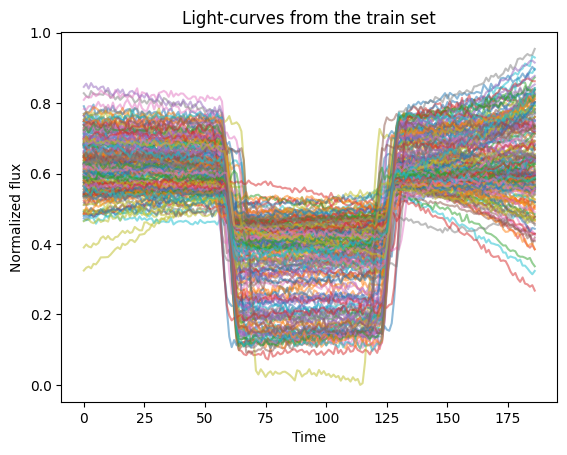

In [11]:
plt.figure()
for i in range(200):
    plt.plot(train_wc[-i], '-', alpha=0.5)
plt.title('Light-curves from the train set')
plt.xlabel('Time')
plt.ylabel('Normalized flux')
plt.show()

# Model train

### 1D CNN

In [12]:
input_wc = Input((187,1))
x = Conv1D(32, 3, activation='relu')(input_wc)
x = MaxPooling1D()(x)
x = BatchNormalization() (x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D()(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D()(x)
x = Conv1D(256, 3, activation='relu')(x)
x = MaxPooling1D()(x)
x = Flatten()(x)

x = Dense(500, activation='relu')(x)
x = Dropout(0.2)(x, training = True)
x = Dense(100, activation='relu')(x)
x = Dropout(0.1)(x, training = True)
output_wc = Dense(1, activation='linear')(x)

model_wc = Model(inputs=input_wc, outputs=output_wc)
model_wc.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 187, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 185, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 92, 32)           0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 92, 32)           128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 90, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 45, 64)           0     

In [13]:
early_stopping = EarlyStopping(
    monitor ='val_loss',
    patience = PATIENCE,
    restore_best_weights = True
)

### Train Model

In [14]:
def scheduler(epoch, lr):
    decay_rate = DECAY_RATE
    decay_step = DECAY_STEP
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

model_wc.compile(optimizer = OPTIMIZER, loss='mse', metrics=[MeanAbsoluteError()])
callback = LearningRateScheduler(scheduler)
checkpoint_filepath = 'output/model_1dcnn.keras'
model_ckt = ModelCheckpoint(
    checkpoint_filepath,
    monitor = 'val_loss',
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = 'min',
    save_freq = 'epoch'
)

history = model_wc.fit(
    x = train_wc,
    y = train_targets_wc_norm,
    validation_data = (valid_wc, valid_targets_wc_norm),
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    shuffle = True,
    verbose = 0,
    callbacks=[model_ckt]
)
print('Done training')

Done training


### Model Eval

#### Learning curve

In [1]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

#### MSE

MC Dropout - prediction result의 평균, 불확실성 추정

In [ ]:
nb_dropout_wc = 1000

def unstandardizing(data, min_train_valid, max_train_valid):
    return data*(max_train_valid - min_train_valid)+min_train_valid

def MC_dropout_WC(model, data, nb_dropout):
    predictions = np.zeros((nb_dropout, data.shape[0]))
    for i in range(nb_dropout):
        predictions[i, :] = model.predict(data, verbose=0).flatten()
    return predictions

if do_the_mcdropout_wc:
    print('Running...')
    prediction_valid_wc = MC_dropout_WC(model_wc, valid_wc, nb_dropout_wc)
    spectre_valid_wc_all = unstandardizing(prediction_valid_wc, min_train_valid_wc, max_train_valid_wc)
    spectre_valid_wc, spectre_valid_std_wc = spectre_valid_wc_all.mean(axis=0), spectre_valid_wc_all.std(axis=0)
    print('Done')
else:
    spectre_valid_wc = model_wc.predict(valid_wc).flatten()
    spectre_valid_wc = unstandardizing(spectre_valid_wc, min_train_valid_wc, max_train_valid_wc)
    spectre_valid_std_wc = 0.1*np.abs(spectre_valid_wc)

Running...
Done


residual 분석

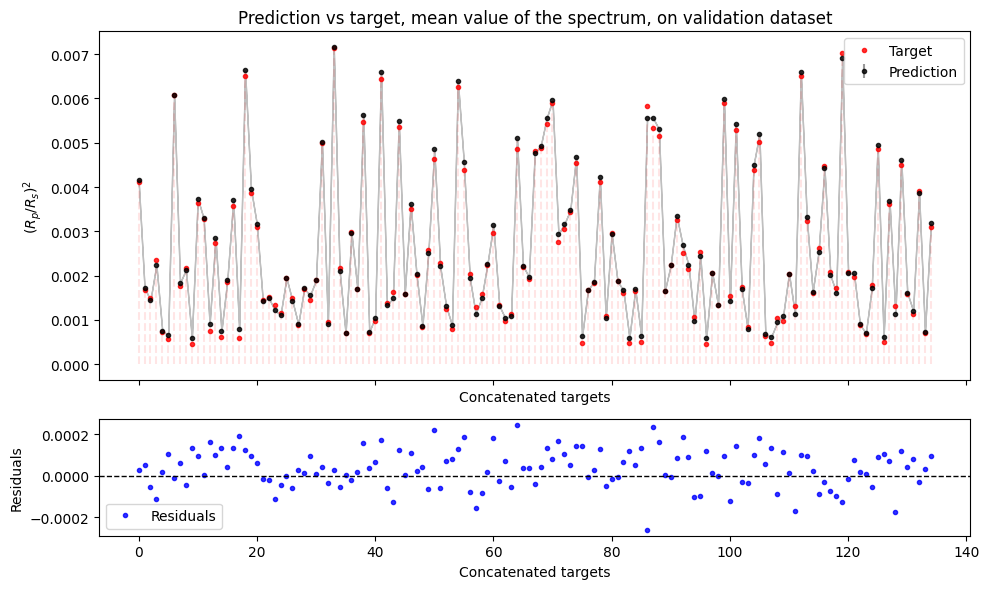

In [ ]:
residuals = spectre_valid_wc - valid_targets_wc
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})
ax1.errorbar(x = np.arange(len(spectre_valid_wc)), y = spectre_valid_wc, yerr =spectre_valid_std_wc, fmt = '.', color = 'k', ecolor = 'gray', label='Prediction', alpha=0.8)
ax1.fill_between(np.arange(len(spectre_valid_wc)), spectre_valid_wc - spectre_valid_std_wc, spectre_valid_wc + spectre_valid_std_wc, color = 'grey', alpha = 0.5)
ax1.vlines(np.arange(len(spectre_valid_wc)),ymin=0, ymax=spectre_valid_wc, colors='r', linestyle='dashed',alpha = 0.1)
ax1.plot(valid_targets_wc, 'r.', label='Target', alpha=0.8)
ax1.set_xlabel('Concatenated targets')
ax1.set_ylabel('$(R_p/R_s)^2$')
ax1.set_title('Prediction vs target, mean value of the spectrum, on validation dataset')
ax1.legend()

ax2.plot(residuals, 'b.', label='Residuals', alpha=0.8)
ax2.set_xlabel('Concatenated targets')
ax2.set_ylabel('Residuals')
ax2.axhline(0, color='black', linestyle='--', linewidth=1)  
ax2.legend()
plt.tight_layout()
plt.show()

In [ ]:
residuals = valid_targets_wc - spectre_valid_wc
print('MSE : ', np.sqrt((residuals**2).mean())*1e6, 'ppm')

MSE :  99.18726850989869 ppm


# Load Model, Testset

완성한 모델, testset 저장해두기. *이후 `model_concat`에서 부를 예정*